# 1. Import Packages and Define Functions

In [113]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod5/Emoji_Analysis/Scripts/')
import config
import warnings
warnings.filterwarnings('ignore')



pd.set_option('display.max_columns', 300)

%matplotlib inline

In [114]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string
import scipy
import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from textblob import TextBlob

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [115]:
from tqdm import tqdm
tqdm.pandas()

In [116]:
# we can define a function that removes stopwords 
def process_tweet(tweet):
    tweet = str(tweet).lower()
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [117]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http","https"]
alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
stopwords += alph

In [118]:
stopwords = list(set(stopwords))

In [119]:
def remove_http(tweet):
    pattern = '((http|https)\w+\s\w+\s\w+\s\w+)'
    try:
        return tweet.replace(re.findall(pattern, tweet)[0][0], "")
    except:
        return tweet

In [120]:
def capital_percentage(tweet):
    tokens = nltk.word_tokenize(tweet)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)

In [121]:
def check_profanity(tweet):
    profane = pd.read_csv("profane_words.csv", header=None)

    profane = list(profane.loc[:,0])
    count = 0
    tweet = tweet.lower()
    tokens = nltk.word_tokenize(tweet)
    for word in tokens:
        if word in profane:
            count += 1
    return count/len(tweet)

In [122]:
def fix_spelling(tweet):
    b = TextBlob(tweet)
    return b.correct()

In [123]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
  
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [124]:
def remove_username(tweet):
    try:
        p = '[\w\s]+(@\w+)'
        return tweet.replace(re.findall(p, tweet)[0], "")
    except:
        return tweet

In [125]:
def clean_txt(tweet):
    tweet = remove_http(tweet)
    tweet = remove_username(tweet)
    tokens = process_tweet(tweet)
    return ' '.join([lemmatizer.lemmatize(w) for w in tokens])
    

In [126]:
analyzer = SentimentIntensityAnalyzer()
def return_sentiment(tweet):
    return analyzer.polarity_scores(tweet)['compound']

# 2. Load in Data and Preprocess

In [127]:
df = pd.read_csv("tweets_4_classes.csv").drop(['Unnamed: 0', 'emoji_frequency'], axis=1)
df.head()

,tweet,sentiment_score,top_emoji
0,Nashies y all know who to vote for @CharlesEst...,0.7424,😊
1,Repost USElection2020 Trump and Covid Jimmy Ki...,0.9231,😊
2,ripdonaldtrump gone and always forgotten have ...,-0.7430,😭
3,Scummo election visit caused an 11 swing to La...,0.9260,😊
4,Titan Medium Lovem Martis Titan Zeus Mars Vote...,0.4587,😊


In [128]:
print(df.tweet.iloc[0])
print(clean_txt(df.tweet.iloc[0]))
print(type(clean_txt(df.tweet.iloc[0])))

Nashies y all know who to vote for @CharlesEsten https t co yn5KOEYOgY
nashies know vote
<class 'str'>


In [129]:
# # Remove "http link stuff from all the tweets"
# print(df.tweet.iloc[0])
# print(remove_http(df.tweet.iloc[0]))

# df.tweet = df.tweet.apply(remove_http)

In [130]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
normalizer = MinMaxScaler()
df.sentiment_score = normalizer.fit_transform(np.array(df.sentiment_score).reshape(-1,1))
df.sentiment_score.describe()

count    1025.000000
mean        0.522611
std         0.319214
min         0.000000
25%         0.229706
50%         0.500427
75%         0.843327
max         1.000000
Name: sentiment_score, dtype: float64

In [131]:
df['capitalization'] = df.tweet.progress_apply(capital_percentage)
df.head()

100%|██████████| 1025/1025 [00:00<00:00, 7111.54it/s]


,tweet,sentiment_score,top_emoji,capitalization
0,Nashies y all know who to vote for @CharlesEst...,0.873586,😊,0.0
1,Repost USElection2020 Trump and Covid Jimmy Ki...,0.964413,😊,0.0
2,ripdonaldtrump gone and always forgotten have ...,0.126967,😭,0.0
3,Scummo election visit caused an 11 swing to La...,0.965871,😊,0.0
4,Titan Medium Lovem Martis Titan Zeus Mars Vote...,0.730988,😊,0.0


In [132]:
df['profanity'] = df.tweet.progress_apply(check_profanity)
df.head()

100%|██████████| 1025/1025 [00:02<00:00, 477.63it/s]


,tweet,sentiment_score,top_emoji,capitalization,profanity
0,Nashies y all know who to vote for @CharlesEst...,0.873586,😊,0.0,0.000000
1,Repost USElection2020 Trump and Covid Jimmy Ki...,0.964413,😊,0.0,0.000000
2,ripdonaldtrump gone and always forgotten have ...,0.126967,😭,0.0,0.013158
3,Scummo election visit caused an 11 swing to La...,0.965871,😊,0.0,0.000000
4,Titan Medium Lovem Martis Titan Zeus Mars Vote...,0.730988,😊,0.0,0.000000


In [158]:
df.top_emoji.value_counts()

😭    418
😊    381
😱    125
😡    101
Name: top_emoji, dtype: int64

# 3. Dummy Classifier for Baseline Model

In [134]:
X = df[['tweet', 'sentiment_score', 'capitalization', 'profanity']]

In [133]:
y =df['top_emoji']

In [135]:
from sklearn.dummy import DummyClassifier

In [136]:
dummy_cf = DummyClassifier()
dummy_cf.fit(X['tweet'],y)
y_preds = dummy_cf.predict(X['tweet'])

print(dummy_cf.score(X['tweet'],y))

0.32195121951219513


In [137]:
accuracy = accuracy_score(y, y_preds)


In [138]:
results=[]
results.append(('Dummy', accuracy))

In [139]:
results

[('Dummy', 0.3297560975609756)]

# 4. Supervised Learning

In [141]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction import DictVectorizer
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [{'cap':  row['capitalization'], 'prof': row['profanity'], 'sent': row['sentiment_score']} for _, row in data.iterrows()]
    

In [142]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text
            ('text', Pipeline([
                ('selector', ItemSelector(key='tweet')),
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 10), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)),
            ])),

            # Pipeline for pulling metadata features
            ('stats', Pipeline([
                ('selector', ItemSelector(key=['capitalization', 'profanity', 'sentiment_score'])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'text': 0.9,
            'stats': 1.5,
        },
    ))
], verbose=True)

In [143]:
seed = 40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [144]:
pipeline.fit(X_train)

[Pipeline] ............. (step 1 of 1) Processing union, total=   0.5s


Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='tweet')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.2,
                                                                                  min_df=3,
                                                                                  ngram_range=(1,
                                                                                               10),
                                                                                  preprocessor=<function clean_txt at 0x1188f9af0>,
                                                                                  smooth_idf=1,
                                                          

In [145]:
%%time
train_vec = pipeline.transform(X_train)
test_vec = pipeline.transform(X_test)
print("Checking that the shapes match: %s - %s" % (train_vec.shape, test_vec.shape))

Checking that the shapes match: (820, 943) - (205, 943)
CPU times: user 388 ms, sys: 6.45 ms, total: 394 ms
Wall time: 395 ms


In [146]:
from sklearn.svm import LinearSVC

In [147]:
#Linear Support Vector Machines
sv_clf = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=seed,verbose=3) 
sv_clf.fit(train_vec, y_train)
test_preds = sv_clf.predict(test_vec)

[LibLinear]

In [148]:
accuracy = accuracy_score(y_test, test_preds)
print('Linear SVC')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('SVM', accuracy))

Linear SVC
Testing Accuracy: 0.722


In [149]:
rfc_clf = RandomForestClassifier(n_estimators=200,random_state=seed,n_jobs=-1,verbose=1)
rfc_clf.fit(train_vec, y_train)
test_preds = rfc_clf.predict(test_vec)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [150]:
accuracy = accuracy_score(y_test, test_preds)
print('Random Forest')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('RFC', accuracy))

Random Forest
Testing Accuracy: 0.7122


In [151]:
#Multinomial Naive Bayes
mnb_clf = MultinomialNB() 
mnb_clf.fit(train_vec, y_train)
test_preds = mnb_clf.predict(test_vec)

In [152]:
accuracy = accuracy_score(y_test, test_preds)
print('MN Bayes')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('MNBayes', accuracy))

MN Bayes
Testing Accuracy: 0.5854


In [153]:
#Bernoulli Naive Bayes
bb_clf = BernoulliNB() 
bb_clf.fit(train_vec, y_train)
test_preds = bb_clf.predict(test_vec)

In [154]:
accuracy = accuracy_score(y_test, test_preds)
print('Bernoulli Bayes')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('BerBayes', accuracy))

Bernoulli Bayes
Testing Accuracy: 0.4244


In [155]:
results

[('Dummy', 0.3297560975609756),
 ('SVM', 0.7219512195121951),
 ('RFC', 0.7121951219512195),
 ('MNBayes', 0.5853658536585366),
 ('BerBayes', 0.424390243902439)]

In [156]:
x = [x[0] for x in results]
y = [x[1] for x in results]

Text(0.5, 1.0, 'Early Results')

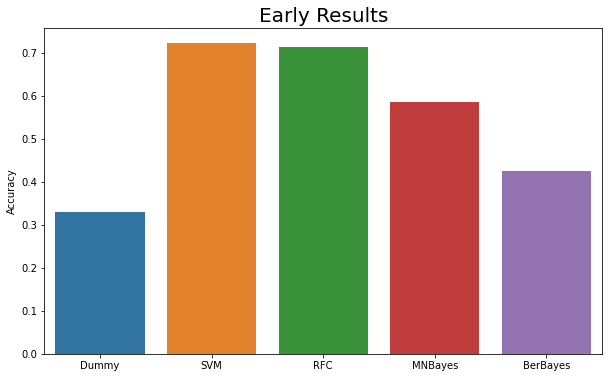

In [157]:
plt.figure(figsize=(10,6))
sns.barplot(x,y)
plt.ylabel('Accuracy')
plt.title("Early Results", fontsize=20)
#plt.savefig("/Users/brianmccabe/Desktop/Early_Results_Selection_Biased")